## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [11]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    for i,n in enumerate(num_neurons):
        if i==0:
            x = keras.layers.Dense(units=n,activation='relu',name='hidden_layer'+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n,activation='relu',name='hidden_layer'+str(i+1))(x)
            x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units,activation='softmax',name='output')(x)
    model = keras.models.Model(inputs=[input_layer],outputs=[out])
    return model

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [9]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]
optimizer_name = ['SGD','Adam','RMSprop']
"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5,0.1]
redice_lr_patient = [3,6,9]

In [13]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print('optimizer:%s'%(str(optim)),"Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor,
                                  patience=reduce_patient,
                                  verbose=1,
                                  min_lr=1e-12,
                                  monitor='val_loss')
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

optimizer:<keras.optimizers.SGD object at 0x000001F345FB9188> Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 3
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_____

50000/50000 [==============================] - 2s 32us/step - loss: 1.2893 - acc: 0.5486 - val_loss: 1.4885 - val_acc: 0.4769
Epoch 13/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.2667 - acc: 0.5569 - val_loss: 1.4704 - val_acc: 0.4838
Epoch 14/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.2460 - acc: 0.5640 - val_loss: 1.4760 - val_acc: 0.4834
Epoch 15/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2237 - acc: 0.5714 - val_loss: 1.4752 - val_acc: 0.4812
Epoch 16/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2047 - acc: 0.5802 - val_loss: 1.4634 - val_acc: 0.4871
Epoch 17/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.1862 - acc: 0.5878 - val_loss: 1.4560 - val_acc: 0.4901
Epoch 18/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.1666 - acc: 0.5957 - val_loss: 1.4508 - val_acc: 0.4901
Epoch 19/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 55us/step - loss: 2.2197 - acc: 0.2691 - val_loss: 2.1726 - val_acc: 0.3053
Epoch 2/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.7566 - acc: 0.3855 - val_loss: 1.7942 - val_acc: 0.3852
Epoch 3/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.6302 - acc: 0.4277 - val_loss: 1.7024 - val_acc: 0.4075
Epoch 4/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.5586 - acc: 0.4521 - val_loss: 1.6370 - val_acc: 0.4260
Epoch 5/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.5049 - acc: 0.4721 - val_loss: 1.5870 - val_acc: 0.4483
Epoch 6/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.4624 - acc: 0.4862 - val_loss: 1.5900 - val_acc: 0.4418
Epoch 7/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.4265 - acc: 0.4986 - val_loss: 1.5513 - val_acc

50000/50000 [==============================] - 2s 33us/step - loss: 1.5737 - acc: 0.4521 - val_loss: 1.6684 - val_acc: 0.4202
Epoch 24/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.5645 - acc: 0.4556 - val_loss: 1.6605 - val_acc: 0.4205
Epoch 25/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.5569 - acc: 0.4578 - val_loss: 1.6569 - val_acc: 0.4239
optimizer:<keras.optimizers.SGD object at 0x000001F345FB9188> Numbers of exp: 5, reduce_factor: 0.10, reduce_patient: 9
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_28 (Batc (None, 256)               1024      

50000/50000 [==============================] - 2s 34us/step - loss: 0.9515 - acc: 0.6711 - val_loss: 1.5050 - val_acc: 0.4810
Epoch 10/25
50000/50000 [==============================] - 2s 34us/step - loss: 0.9014 - acc: 0.6901 - val_loss: 1.4812 - val_acc: 0.4899
Epoch 11/25
50000/50000 [==============================] - 2s 34us/step - loss: 0.8643 - acc: 0.7030 - val_loss: 1.5283 - val_acc: 0.4833
Epoch 12/25
50000/50000 [==============================] - 2s 33us/step - loss: 0.8348 - acc: 0.7127 - val_loss: 1.5495 - val_acc: 0.4803
Epoch 13/25
50000/50000 [==============================] - 2s 34us/step - loss: 0.8036 - acc: 0.7248 - val_loss: 1.4677 - val_acc: 0.5031
Epoch 14/25
50000/50000 [==============================] - 2s 33us/step - loss: 0.7688 - acc: 0.7376 - val_loss: 1.6235 - val_acc: 0.4635
Epoch 15/25
50000/50000 [==============================] - 2s 33us/step - loss: 0.7377 - acc: 0.7474 - val_loss: 1.5578 - val_acc: 0.4830
Epoch 16/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.9854 - acc: 0.3255 - val_loss: 1.8451 - val_acc: 0.3699
Epoch 2/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.6332 - acc: 0.4289 - val_loss: 1.7238 - val_acc: 0.3987
Epoch 3/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.5366 - acc: 0.4630 - val_loss: 1.6456 - val_acc: 0.4216
Epoch 4/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.4767 - acc: 0.4835 - val_loss: 1.5910 - val_acc: 0.4412
Epoch 5/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.4315 - acc: 0.5023 - val_loss: 1.5811 - val_acc: 0.4411
Epoch 6/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.3946 - acc: 0.5114 - val_loss: 1.5411 - val_acc: 0.4508
Epoch 7/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.3617 - acc: 0.5249 - val_loss: 1.5294 - val_acc

50000/50000 [==============================] - 2s 34us/step - loss: 1.0696 - acc: 0.6367 - val_loss: 1.4316 - val_acc: 0.4982
Epoch 24/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.0582 - acc: 0.6397 - val_loss: 1.4304 - val_acc: 0.5016
Epoch 25/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.0461 - acc: 0.6450 - val_loss: 1.4260 - val_acc: 0.5025
optimizer:<keras.optimizers.Adam object at 0x000001F346153288> Numbers of exp: 10, reduce_factor: 0.10, reduce_patient: 6
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_43 (Batc (None, 256)               1024   

Epoch 9/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.8197 - acc: 0.3724 - val_loss: 1.8766 - val_acc: 0.3528
Epoch 10/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.8001 - acc: 0.3777 - val_loss: 1.8584 - val_acc: 0.3569
Epoch 11/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.7829 - acc: 0.3842 - val_loss: 1.8442 - val_acc: 0.3620
Epoch 12/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.7671 - acc: 0.3882 - val_loss: 1.8304 - val_acc: 0.3663
Epoch 13/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.7529 - acc: 0.3924 - val_loss: 1.8177 - val_acc: 0.3733
Epoch 14/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.7396 - acc: 0.3952 - val_loss: 1.8090 - val_acc: 0.3733
Epoch 15/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.7281 - acc: 0.4003 - val_loss: 1.7980 - val_acc: 0.3767
Epoch 16/25
50000/50000 [==========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 76us/step - loss: 2.2980 - acc: 0.2445 - val_loss: 2.1567 - val_acc: 0.2884
Epoch 2/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.9406 - acc: 0.3325 - val_loss: 1.9628 - val_acc: 0.3407
Epoch 3/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.8065 - acc: 0.3737 - val_loss: 1.8624 - val_acc: 0.3652
Epoch 4/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.7175 - acc: 0.4028 - val_loss: 1.7966 - val_acc: 0.3840
Epoch 5/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.6539 - acc: 0.4216 - val_loss: 1.7479 - val_acc: 0.3971
Epoch 6/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.6027 - acc: 0.4392 - val_loss: 1.7067 - val_acc: 0.4113
Epoch 7/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.5591 - acc: 0.4531 - val_loss: 1.6645 - val_acc

50000/50000 [==============================] - 2s 34us/step - loss: 1.2177 - acc: 0.5802 - val_loss: 1.5111 - val_acc: 0.4728
Epoch 24/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2033 - acc: 0.5839 - val_loss: 1.5097 - val_acc: 0.4726
Epoch 25/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.1907 - acc: 0.5910 - val_loss: 1.4947 - val_acc: 0.4784
optimizer:<keras.optimizers.RMSprop object at 0x000001F346153748> Numbers of exp: 15, reduce_factor: 0.10, reduce_patient: 3
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_58 (Batc (None, 256)               1024

50000/50000 [==============================] - 2s 33us/step - loss: 1.5018 - acc: 0.4738 - val_loss: 1.6433 - val_acc: 0.4275
Epoch 10/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.4728 - acc: 0.4850 - val_loss: 1.6294 - val_acc: 0.4299
Epoch 11/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.4457 - acc: 0.4944 - val_loss: 1.6244 - val_acc: 0.4287
Epoch 12/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.4227 - acc: 0.5033 - val_loss: 1.6004 - val_acc: 0.4429
Epoch 13/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.4006 - acc: 0.5118 - val_loss: 1.6006 - val_acc: 0.4386
Epoch 14/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.3793 - acc: 0.5187 - val_loss: 1.5678 - val_acc: 0.4492
Epoch 15/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.3598 - acc: 0.5271 - val_loss: 1.5584 - val_acc: 0.4517
Epoch 16/25
50000/50000 [=====================

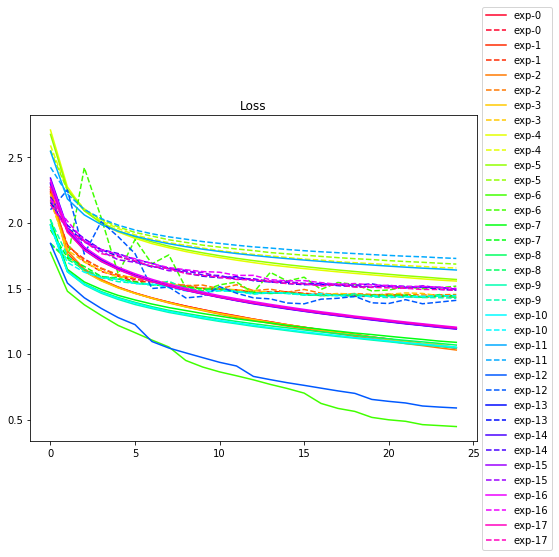

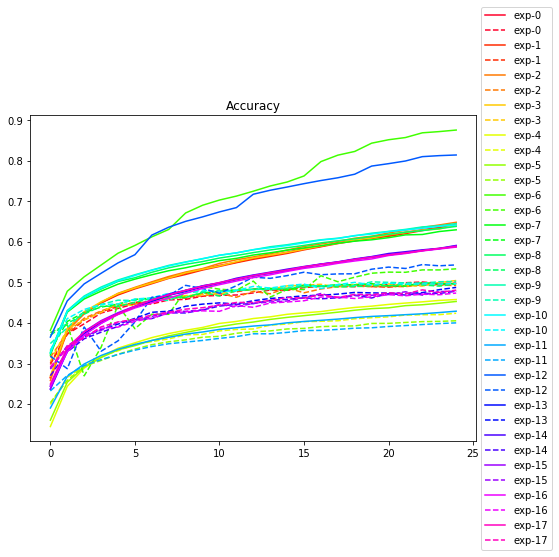

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()